In [1]:
"""
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
"""

'\n# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python\n# For example, here\'s several helpful packages to load\n\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" \n# You can also write temporary files to /kaggle/temp/, but they won\'t be saved outside of the current session\n'

In [2]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

# **Brief description of the problem and data**

We have in our hands a set of 7613 tweets, some of them with information regarding location from where there were sent and some of them with keywords. The target or label will be 1 when tweet is about a disaster and 0 otherwise.\
Objective is to clasify them as disaster or not, so binary class classification.

# *EDA*
**Lest go with data reading some basic exploration on this cells.**\
We can see a little unbalance between real disasters and other tweets (as expected disasters are less frecuent). There are lot of missing info (on location and keywords which may be not that important but we can`t know that yet). Fortunately missing info is aparently random because class distribution is the same before and after removing those items. 

I will stay with both databases mainly because we will lose 1/3 of data when filtering. Objective now is to use calssifiers with both databases to see if it will make a big diference when classifing items.

In [3]:
#Read
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv') 
df_train_filtered = df_train.copy()  # Duplicate the dataset
df_train_filtered.dropna(inplace=True)  # Remove rows with null values

----Shape----
7613
----Columns----
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
----Head----
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
----Info----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object

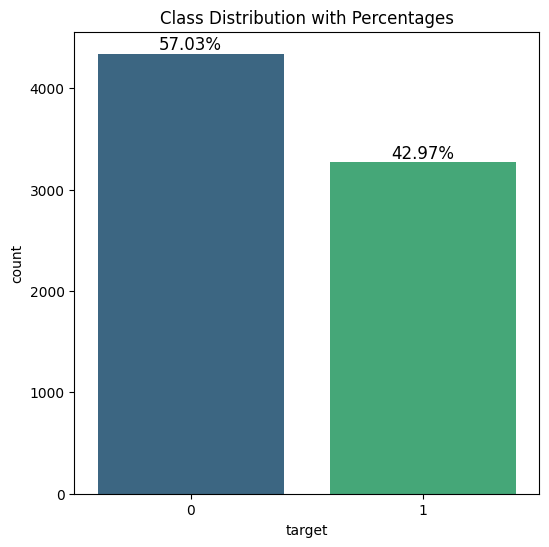

In [4]:
#Exploring Dataset 
#NN

print ('----Shape----')
print (df_train.shape[0])
print ('----Columns----')
print (df_train.columns)
print ('----Head----')
print(df_train.head())
print ('----Info----')
df_train.info()
print ('----Null values on important columns (text and target)----')
text = df_train['text'].isnull().sum()
target = df_train['target'].isnull().sum()
print (text, target)
print ('----Details----')
loc = df_train['location'].nunique()
word = df_train['keyword'].nunique()
print (f'there are {loc} diferent places, and {word} keywords')

#Distribution of classes
plt.figure(figsize=(6,6))
ax = sns.countplot(data=df_train, x='target', palette='viridis')
# Add percentages on bars
for p in ax.patches:
    percentage = f'{100 * p.get_height() / df_train.shape[0]:.2f}%'  # Calculate %
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')
plt.title('Class Distribution with Percentages')
plt.show()

----Shape----
5080
----Info----
<class 'pandas.core.frame.DataFrame'>
Index: 5080 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5080 non-null   int64 
 1   keyword   5080 non-null   object
 2   location  5080 non-null   object
 3   text      5080 non-null   object
 4   target    5080 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 238.1+ KB


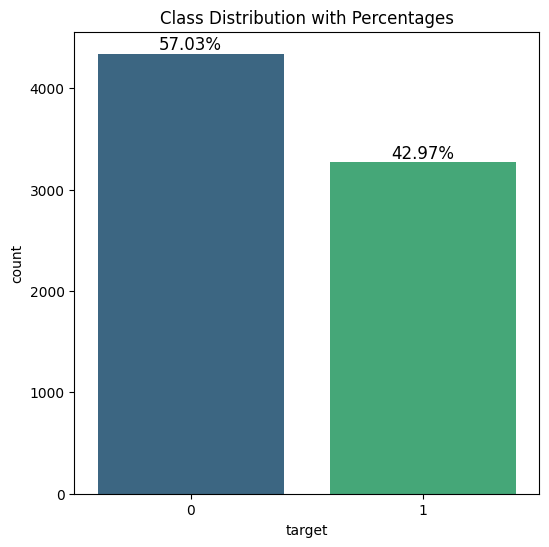

In [5]:
#After getting rid of rows with incomplete information

print ('----Shape----')
print (df_train_filtered.shape[0])
print ('----Info----')
df_train_filtered.info()

#Distribution of classes
plt.figure(figsize=(6,6))
ax = sns.countplot(data=df_train, x='target', palette='viridis')
# Add percentages on bars
for p in ax.patches:
    percentage = f'{100 * p.get_height() / df_train.shape[0]:.2f}%'  # Calculate %
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')
plt.title('Class Distribution with Percentages')
plt.show()

**Look into vocabulary **
I am goint to use tokenizer from keras for this part. 

check: https://keras.io/keras_hub/api/tokenizers/tokenizer/


In [6]:
#number of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'])
word_index = tokenizer.word_index  # Dictionary of word-to-index mapping
vocab_size = len(word_index)  # Total unique words in vocabulary
print(f"Vocabulary Size: {vocab_size}")

#top used words
word_counts = tokenizer.word_counts
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

print(sorted_words[:50])

Vocabulary Size: 22700
[('t', 4749), ('co', 4739), ('http', 4308), ('the', 3239), ('a', 2195), ('in', 1983), ('to', 1948), ('of', 1825), ('and', 1423), ('i', 1397), ('is', 950), ('for', 892), ('on', 859), ('you', 792), ('my', 675), ('with', 572), ('that', 567), ('it', 565), ('at', 538), ('by', 519), ('this', 478), ('from', 422), ('https', 412), ('are', 402), ('be', 402), ('was', 386), ('have', 383), ('like', 348), ('amp', 344), ('as', 330), ('up', 328), ('me', 326), ('but', 321), ('just', 319), ('so', 316), ('not', 297), ('your', 291), ('out', 273), ('no', 266), ('all', 259), ('after', 259), ('will', 258), ('an', 249), ('has', 249), ('fire', 245), ("i'm", 240), ('when', 240), ('if', 234), ('we', 228), ('get', 228)]


**Removing Stopwords**
After looking a little into most used words it seem most of them are practically stop words and links, so lets remove them.
Links can be usefull but we need to group them and make them binary (tweet has a link or no).
re or regular expresion docs are found here:

https://docs.python.org/3/library/re.html#regular-expression-syntax.

https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [7]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer

personal_words = {'t', 'co', 'http', 'https', 'the', 'a', 'u', 'rt', 'in', 'to', 'of', 'and', 'i','im', 'its', 'is', 
                  'for', 'on', 'you', 'my', 'with', 'that', 'it', 'at', 'by', 'this', 'from', 'are', 
                  'be', 'was', 'amp', 'as', 'me', 'so', 'not', 'your', 'out', 'no'}

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http[s]?://\S+', 'url', text)  # Replace links with 'URL'   
    text = re.sub(r'[^a-z\s]', '', text)  # Remove numbers, punctuation, and special chars
    words = text.split()
    words = [word for word in words if word not in personal_words]  # Remove stopwords

    if not words:  # If all words are removed, keep at least the 'URL' marker
        return 'URL' if 'URL' in text else ''  

    return ' '.join(words)
    
# Apply cleaning function
df_train['clean_text'] = df_train['text'].astype(str).apply(clean_text)

# Tokenize again without stopwords
tokenizer_filtered = Tokenizer()
tokenizer_filtered.fit_on_texts(df_train['clean_text'])

# Get word frequencies
word_counts_filtered = tokenizer_filtered.word_counts
sorted_words_filtered = sorted(word_counts_filtered.items(), key=lambda x: x[1], reverse=True)

# Print top 50 most common words
print("Top 50 most common words:")
for word, count in sorted_words_filtered[:25]:
    print(f"{word}: {count}")

word_index_filtered = tokenizer_filtered.word_index  # Dictionary of word-to-index mapping
vocab_size_filtered = len(word_index_filtered)  # Total unique words in vocabulary
print(f"Vocabulary Size: {vocab_size_filtered}")

Top 50 most common words:
url: 4710
have: 386
like: 345
up: 321
just: 320
but: 317
after: 259
all: 258
will: 257
when: 255
fire: 252
an: 252
has: 249
if: 242
we: 238
get: 229
new: 226
now: 222
via: 220
more: 217
about: 214
dont: 208
or: 203
what: 199
news: 198
Vocabulary Size: 16869


**Plots and graphs** after filtering and removing stopwords and punctuation (take a look at total number of words).

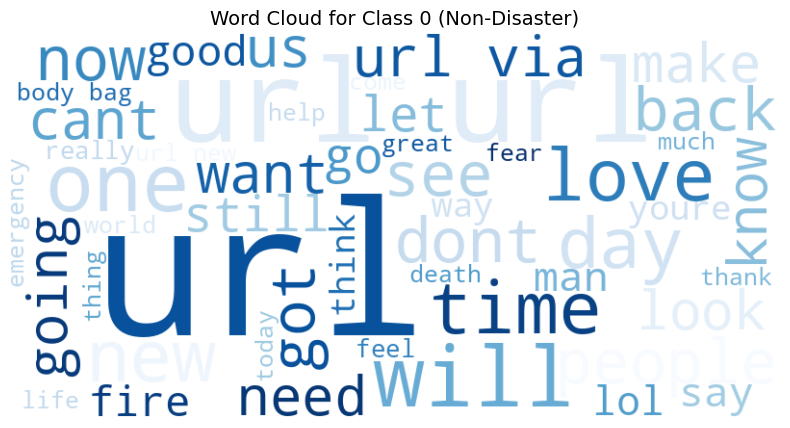

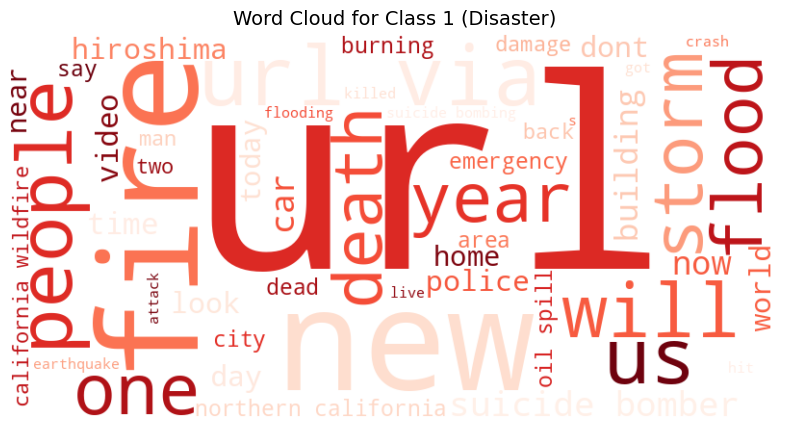

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud for a specific class
def generate_wordcloud(target_class, color):
    text = " ".join(df_train[df_train['target'] == target_class]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap=color, max_words=50).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Class {target_class} ({'Disaster' if target_class == 1 else 'Non-Disaster'})", fontsize=14)
    plt.show()

# Generate word clouds
generate_wordcloud(0, "Blues")  # Non-Disaster (Class 0) in blue shades
generate_wordcloud(1, "Reds")   # Disaster (Class 1) in red shades


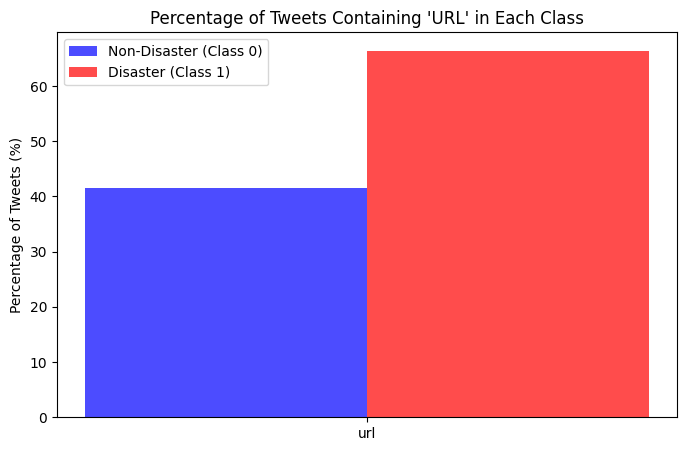

In [9]:
import matplotlib.pyplot as plt

# Function to calculate percentage of tweets containing a specific word
def word_percentage(word):
    class_0_count = df_train[df_train['target'] == 0]['clean_text'].apply(lambda x: word in x).mean() * 100
    class_1_count = df_train[df_train['target'] == 1]['clean_text'].apply(lambda x: word in x).mean() * 100
    return class_0_count, class_1_count

# Get percentages
url_pct_0, url_pct_1 = word_percentage("url")  # URLs

# Prepare data for plotting
words = ["url"]
class_0_values = [url_pct_0]
class_1_values = [url_pct_1]

# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.4
index = range(len(words))

# Plot bars for both classes
ax.bar(index, class_0_values, bar_width, label="Non-Disaster (Class 0)", color="blue", alpha=0.7)
ax.bar([i + bar_width for i in index], class_1_values, bar_width, label="Disaster (Class 1)", color="red", alpha=0.7)

# Formatting
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(words)
ax.set_ylabel("Percentage of Tweets (%)")
ax.set_title("Percentage of Tweets Containing 'URL' in Each Class")
ax.legend()

plt.show()


# Model Architecture


In the next steps we are going to try different aproaches.

This is first model. Using just the text of the tweets and a simple secuential model.

In [10]:
#imports
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model

**Model 1**

This model is:
1. Converting words into tokens
2. Converting sentences into secuence of tokens
3. Padding those secences to the longest secuence - 8
4. Secuential model as follows
* 4.1. Embeding layer: Maps 10000 most used words to a 128 vector for understanding words relationships
* 4.2 LSTM layer with Regularization
* 4.3 Dense layer as a classifier (disaster or not tweet)

"**Embedding**
The embedding layer represents data, such as words or categories, in a more meaningful form by converting them into numerical vectors that a machine can understand. It is commonly used in Natural Language Processing (NLP) and recommendation systems to handle categorical data. Since computers can only process numbers, an embedding layer helps convert large sets of data into smaller, more efficient vectors, making it easier for the machine to learn patterns.

The main uses of embedding layers include:

Reduce Dimensionality: It compresses high-dimensional data into a more manageable size.
Capture Relationships: It enables the model to understand relationships between different inputs, such as words in a sentence.
Improve Efficiency: By using dense vectors, the model processes data faster and more effectively."*

* Taken directly from: https://www.geeksforgeeks.org/what-is-embedding-layer/



In [11]:
# Model 1 - Text on full DB -with filtered text
"""
------
Data preparation 
------
"""
# Set VOCAB_SIZE dynamically based on analysis
tokenizer1 = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer1.fit_on_texts(df_train['text'])
# Convert tweets to sequences
sequences1 = tokenizer1.texts_to_sequences(df_train['clean_text'])
# Padding
MAX_LENGTH = (max(len(seq) for seq in sequences1)) - 8
padded_sequences1 = pad_sequences(sequences1, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Labels
labels = np.array(df_train['target'])
X_train, X_val, y_train, y_val = train_test_split(padded_sequences1, labels, test_size=0.2, random_state=42)

# Checks 
print(df_train['clean_text'].iloc[1])  # Original text
print(sequences1[1])  # Tokenized version
print(padded_sequences1[0])  # Padded tokenized tweet

"""
------
Model Build and Train
------
"""

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=MAX_LENGTH),
    LSTM(64, return_sequences=False),  # LSTM layer with Regularization
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile 
optimizer = Adam(learning_rate=0.00025)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
# Train the model
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

forest fire near la ronge sask canada
[190, 46, 230, 800, 6955, 6956, 1405]
[ 120 4634  869  264  139 1620 4635   90   41    0    0    0    0    0
    0    0]
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - binary_accuracy: 0.5876 - loss: 0.6637 - val_binary_accuracy: 0.7899 - val_loss: 0.4651
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.8474 - loss: 0.3698 - val_binary_accuracy: 0.7781 - val_loss: 0.4863
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.8930 - loss: 0.2766 - val_binary_accuracy: 0.7938 - val_loss: 0.4577
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9194 - loss: 0.2257 - val_binary_accuracy: 0.7807 - val_loss: 0.5264
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9407 - loss: 0.1748 - val_binary_accuracy: 0.7722 - val_loss: 0.5874
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9543 - loss: 0.1429 - val_binary_accuracy: 0.7748 - val_loss: 0.7493
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9565 - loss: 0.1257 - val_binary_accuracy: 0.7623 - val_loss: 0.7262
Epoch 8/10

**Model 2: Hyperparameter Tuning**

Model is acceptable, but lets play with parameters. 
In this section the objective is to move around embedding dimensions, LSTM units, use L2 regularization for penalty, use Dopout with various values, change adam learning rate and iterate over the model to get best parameters.
For the first tunning, when looking at base model performance 2 Epochs seems to work fine, after that we get some overfitting

In [12]:
# Function to build the model dynamically
"""
------
Searching best parameters
------
"""

def build_model(hp):
    model = Sequential([
        Embedding(input_dim=10000, 
                  output_dim=hp.Choice('embedding_dim', [64, 128, 256]), 
                  input_length=MAX_LENGTH),
        LSTM(hp.Choice('lstm_units', [32, 64, 128]), 
             return_sequences=False, 
             kernel_regularizer=l2(hp.Choice('l2_reg', [0.01, 0.05, 0.1]))),
        Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.00025]))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_binary_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuning',
    project_name='lstm_tuning'
)

# Start hyperparameter tuning
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history2 = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2,
    batch_size=32
)


Reloading Tuner from my_tuning/lstm_tuning/tuner0.json
Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - binary_accuracy: 0.6285 - loss: 1.1008 - val_binary_accuracy: 0.7997 - val_loss: 0.4751
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - binary_accuracy: 0.8652 - loss: 0.3670 - val_binary_accuracy: 0.8056 - val_loss: 0.4455


**Model 3: with database without NaN**

Model 2 is going to be trained taking into account more parameters and trainning with second database. 

In [13]:
#Model with best parameters - filtered database
"""
------
 Data preparation 
------
"""
df_train_filtered = df_train.copy()  # Duplicate the dataset
df_train_filtered.dropna(inplace=True)  # Remove rows with null values

tokenizer3 = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer3.fit_on_texts(df_train_filtered['clean_text'])
sequences3 = tokenizer3.texts_to_sequences(df_train_filtered['clean_text'])
MAX_LENGTH3 = max(len(seq) for seq in sequences3)
padded_sequences3 = pad_sequences(sequences3, maxlen=MAX_LENGTH, padding='post', truncating='post')
labels3 = np.array(df_train_filtered['target'])
X_train3, X_val3, y_train3, y_val3 = train_test_split(padded_sequences3, labels3, test_size=0.2, random_state=42)
"""
------
Model Build and Train
------
"""
#Model with filtered data
history3 = best_model.fit(
    X_train3, y_train3,
    validation_data=(X_val3, y_val3),
    epochs=2,
    batch_size=32
)

Epoch 1/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.6015 - loss: 0.6812 - val_binary_accuracy: 0.7618 - val_loss: 0.5255
Epoch 2/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.8530 - loss: 0.3799 - val_binary_accuracy: 0.7913 - val_loss: 0.4846


**Model 4: with all variables**

We have some data like keywords and location. let's include them in the model.
For this we are going to need to encode keyword and location. one-hot encode is okay here because we don`t nedd to capture relationships on various words
then we need to merge info from LSTM and categorical information and see if the classifier gets better with more info.

In [14]:
#Model with all variables - Filtered DB
"""
------
Data preparation 
------
"""
# One-hot encode `keyword` and `location`
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
structured_features = encoder.fit_transform(df_train_filtered[['keyword', 'location']])

# Convert to numpy
structured_features = np.array(structured_features)

tokenizer4 = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer4.fit_on_texts(df_train_filtered['clean_text'])
sequences4 = tokenizer4.texts_to_sequences(df_train_filtered['clean_text'])
MAX_LENGTH4 = max(len(seq) for seq in sequences4)
padded_sequences4 = pad_sequences(sequences4, maxlen=MAX_LENGTH, padding='post', truncating='post')
labels4 = np.array(df_train_filtered['target'])
X_train4, X_val4, y_train4, y_val4 = train_test_split(padded_sequences4, labels4, test_size=0.2, random_state=42)
"""
------
Model Build and Train
------
"""
# Text input (LSTM part)
text_input = Input(shape=(MAX_LENGTH,), name="text_input")
embedding = Embedding(input_dim=10000, output_dim=128)(text_input)
lstm = LSTM(64)(embedding)

# Structured input (categorical features)
structured_input = Input(shape=(structured_features.shape[1],), name="structured_input")
dense_features = Dense(32, activation='relu')(structured_input)

# Merge both inputs
merged = Concatenate()([lstm, dense_features])
output = Dense(1, activation='sigmoid')(merged)

# Define the model
model4 = Model(inputs=[text_input, structured_input], outputs=output)

# Compile model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

history4 = model4.fit(
    [padded_sequences4, structured_features],  # Input: [Text + Structured]
    labels4,  # Target labels
    validation_split=0.2,
    epochs=2,
    batch_size=32
)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - binary_accuracy: 0.6285 - loss: 0.6391 - val_binary_accuracy: 0.7648 - val_loss: 0.4883
Epoch 2/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - binary_accuracy: 0.8857 - loss: 0.2906 - val_binary_accuracy: 0.7372 - val_loss: 0.5339


Very similar performance as base model, so i wont waste time tuning parameters here. les's move on

**Model 5**

Finally we are going to test a simple model using just keywords; using filtered data.

In [15]:
#Model with only keywords
"""
------
Data preparation 
------
"""
tokenizer5 = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer5.fit_on_texts(df_train_filtered['keyword'])
sequences5 = tokenizer.texts_to_sequences(df_train_filtered['keyword'])
MAX_LENGTH = max(len(seq) for seq in sequences5)
padded_sequences5 = pad_sequences(sequences5, maxlen=MAX_LENGTH, padding='post', truncating='post')
labels5 = np.array(df_train_filtered['target'])
X_train5, X_val5, y_train5, y_val5 = train_test_split(padded_sequences5, labels5, test_size=0.2, random_state=42)

"""
------
Model Build and Train
------
"""

#Model with filtered data
history5 = best_model.fit(
    X_train5, y_train5,
    validation_data=(X_val5, y_val5),
    epochs=2,
    batch_size=32
)

Epoch 1/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - binary_accuracy: 0.5529 - loss: 0.6992 - val_binary_accuracy: 0.5748 - val_loss: 0.6917
Epoch 2/2
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.5511 - loss: 0.6913 - val_binary_accuracy: 0.5748 - val_loss: 0.6861


# Results
After testing various models we will stay with the model 2 that was trained only with text from tweets and with best parameters

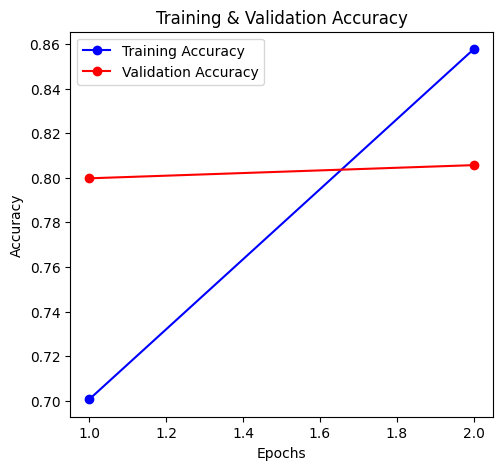

In [16]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
history_dict = history2.history

train_acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

# Conclusion & submission

In conclusion i did:
1. Model 1 using text from tweets and relating it with class
2. Model 2 is testing hyperparametes for model 1 and improving its performance **(this one is overall best)**
4. Model 3 is Model 2 trained just with those cases where location and keyword was avalible
5. Model 4 is A hybrid model with LSTM and info obtained from location or keyword. Because of this it was only trained with the database where location and keyword was avalible
6. Model 5 is the simplest model just taking into account the info from kewyord. 

First 4 models perform very similarly (near to 0.8 on binary accuracy), all of this models start to overfit preatty fast so we did early stopped preatty fast.
For further improvement i suspect we net to better filter data and maybe test alternative embeddings and words tokens.

In [17]:
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
tokenizer_final = Tokenizer ()
final_test_sequences = tokenizer_final.texts_to_sequences(df_test['text'])  # Assuming df_test is your test DataFrame
padded_test_sequences = pad_sequences(final_test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
#Predict probabilities
y_pred_prob = best_model.predict(padded_test_sequences)
# Convert probabilities to binary labels (threshold = 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Convert to DataFrame
submission = pd.DataFrame({'id': df_test['id'], 'target': y_pred.flatten()})

# Save as CSV
submission.to_csv('submission.csv', index=False)

print("Predictions saved successfully!")


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions saved successfully!


In [18]:
# !rm -rf /kaggle/working/*